### 4. CNN Свертки<br>
- Обучите CNN (самописная) на CIFAR-100.<br>
- Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.<br>
- Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torchsummary import summary
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm
from torch import optim
from IPython.display import clear_output
import time

from sklearn.model_selection import train_test_split

In [2]:
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable


 Загрузим датасет CIFAR-10 (не хватило вычислительной мощности для обработки Cifar-100)

In [3]:
dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,  
                                             download=True)

Files already downloaded and verified


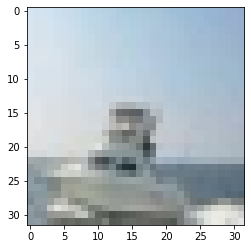

In [4]:
plt.imshow(dataset[100][0])
plt.show()

Разобъем датасет на тренировочную и валидационную выборки, обернем в dataloader

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,
                                             transform=transforms.ToTensor(),
                                             download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)


test_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                            train=False,
                                            transform=transforms.ToTensor(),
                                            download=True,)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=8,
                                          shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


Зададим устройство

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Создадим свою архитектуру сети на подобии рассмотренной на уроке, но с некоторыми преобразованиями.

In [7]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_one = nn.Dropout(0.2)
        self.dp_two = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 64, 3)
        self.bn_two = torch.nn.BatchNorm2d(64) 
        self.conv_two = torch.nn.Conv2d(64, 128, 3)
        self.bn_three = torch.nn.BatchNorm2d(128)
        self.conv_three = torch.nn.Conv2d(128, 256, 3)
        self.bn_four = torch.nn.BatchNorm2d(256)
        self.fc1 = torch.nn.Linear(1024, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.out = torch.nn.Linear(256, 100)
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_one(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_two(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)
       
net = Net().to(device)
print(net)

Net(
  (dp_one): Dropout(p=0.2, inplace=False)
  (dp_two): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=100, bias=True)
)


In [8]:
optimizer = torch.optim.Adagrad(net.parameters(), lr=0.01) #используется оптимизатор Adagrad
criterion = nn.CrossEntropyLoss()

In [9]:
summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 64, 30, 30]           1,792
       BatchNorm2d-3           [-1, 64, 15, 15]             128
            Conv2d-4          [-1, 128, 13, 13]          73,856
       BatchNorm2d-5            [-1, 128, 6, 6]             256
            Conv2d-6            [-1, 256, 4, 4]         295,168
       BatchNorm2d-7            [-1, 256, 2, 2]             512
           Dropout-8                 [-1, 1024]               0
            Linear-9                  [-1, 512]         524,800
          Dropout-10                  [-1, 512]               0
           Linear-11                  [-1, 256]         131,328
           Linear-12                  [-1, 100]          25,700
Total params: 1,053,546
Trainable params: 1,053,546
Non-trainable params: 0
---------------------------

Приступим к обучению сети

In [10]:
def learn_net(net, criterion, optimizer, num_epochs):
    train_acc = []
    test_acc = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_items = 0.0
        running_loss_test = 0.0
        running_items_test = 0.0
        running_right = 0.0
        running_right_test = 0.0

        net.train()
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)# Обнуляим градиент
            optimizer.zero_grad() #предсказание
            outputs = net(inputs) #лосс
            loss = criterion(outputs, labels) #шаг назад по лоссу
            loss.backward() #шаг оптимайзера
            optimizer.step()

          
            running_loss += loss.item() #статистика о процессе обучения
            running_items += len(labels)
            running_right += (labels == torch.max(outputs, 1)[1]).sum()

        running_right = running_right.item() 
        print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
            f'Loss_train: {running_loss / (i + 1):.3f}. ' \
            f'Acc: {running_right / running_items:.3f}.', end=' ')
        acc = running_right / running_items
        train_acc.append(acc)
     
        running_loss, running_items, running_right = 0.0, 0.0, 0.0

        net.eval()
        for i, data in enumerate(test_loader):
            inputs, labels = data[0].to(device), data[1].to(device) #предсказание
            outputs = net(inputs) 
            loss = criterion(outputs, labels)

            running_loss_test += loss.item()
            running_items_test += len(labels)
            running_right_test += (labels == torch.max(outputs, 1)[1]).sum()

        running_right_test = running_right_test.item()
        print(f'Loss_test: {running_loss_test / (i + 1):.3f}. ' \
            f'Acc_test: {running_right_test / running_items_test:.3f}')
        test_acc.append(running_right_test / running_items_test)
        running_loss_test, running_items_test, running_right_test = 0.0, 0.0, 0.0

    return train_acc, test_acc

In [18]:
%%time
train_acc, test_acc = learn_net(net, criterion, optimizer, 10)

Epoch [1/10]. Loss_train: 1.272. Acc: 0.546. Loss_test: 1.025. Acc_test: 0.631
Epoch [2/10]. Loss_train: 0.838. Acc: 0.703. Loss_test: 0.769. Acc_test: 0.727
Epoch [3/10]. Loss_train: 0.676. Acc: 0.762. Loss_test: 0.685. Acc_test: 0.760
Epoch [4/10]. Loss_train: 0.573. Acc: 0.800. Loss_test: 0.692. Acc_test: 0.763
Epoch [5/10]. Loss_train: 0.495. Acc: 0.825. Loss_test: 0.753. Acc_test: 0.747
Epoch [6/10]. Loss_train: 0.427. Acc: 0.849. Loss_test: 0.655. Acc_test: 0.784
Epoch [7/10]. Loss_train: 0.370. Acc: 0.869. Loss_test: 0.679. Acc_test: 0.784
Epoch [8/10]. Loss_train: 0.323. Acc: 0.885. Loss_test: 0.662. Acc_test: 0.795
Epoch [9/10]. Loss_train: 0.280. Acc: 0.902. Loss_test: 0.661. Acc_test: 0.793
Epoch [10/10]. Loss_train: 0.240. Acc: 0.915. Loss_test: 0.691. Acc_test: 0.795
CPU times: total: 3h 42min 49s
Wall time: 1h 2min 53s


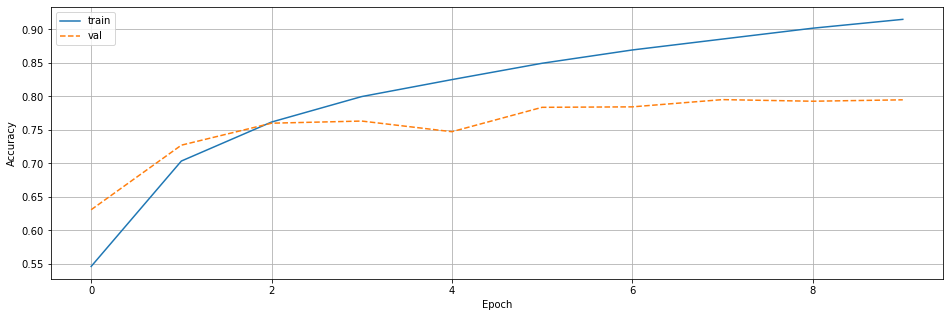

In [19]:
plt.figure(figsize = (16,5))
plt.plot(train_acc,'-',label = f'train')
plt.plot(test_acc,'--',label = f'val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()  

Мы получили весьма впечатляющие результаты на конец обучения:Loss_train: 0.240. Acc: 0.915. Loss_test: 0.691. Acc_test: 0.795

На тесте качество немного просело между 4 и 5 эпохами, но далее выровнялось и показало уверенный равномерный рост. Время обучения более часа.

Загрузим предтренированную модель

In [11]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)
print(resnet50)

C:\Users\Инна\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Инна\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
summary(resnet50.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Нужно предварительно заблокировать предтренированные слои

In [13]:
for param in list(resnet50.parameters())[:]:
    param.requires_grad = False

Переназначим последний плотный слой на классификацию 100 объектов

In [14]:
resnet50.fc = nn.Linear(2048, 100)

summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [15]:
resnet50 = resnet50.to(device)

Подготовим и обучим нашу сеть 

In [16]:
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True,
                                             transform=transforms.ToTensor(),
                                             download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)


test_dataset = torchvision.datasets.CIFAR10(root='./data', 
                                            train=False,
                                            transform=transforms.ToTensor(),
                                            download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=8,
                                          shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [17]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adagrad(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [18]:
%%time
train_acc, test_acc = learn_net(resnet50, criterion, optimizer, 10)

Epoch [1/10]. Loss_train: 1.950. Acc: 0.349. Loss_test: 1.787. Acc_test: 0.416
Epoch [2/10]. Loss_train: 1.750. Acc: 0.419. Loss_test: 1.706. Acc_test: 0.443
Epoch [3/10]. Loss_train: 1.699. Acc: 0.429. Loss_test: 1.668. Acc_test: 0.449
Epoch [4/10]. Loss_train: 1.665. Acc: 0.442. Loss_test: 1.651. Acc_test: 0.449
Epoch [5/10]. Loss_train: 1.647. Acc: 0.449. Loss_test: 1.625. Acc_test: 0.460
Epoch [6/10]. Loss_train: 1.630. Acc: 0.452. Loss_test: 1.616. Acc_test: 0.466
Epoch [7/10]. Loss_train: 1.615. Acc: 0.457. Loss_test: 1.604. Acc_test: 0.465
Epoch [8/10]. Loss_train: 1.609. Acc: 0.460. Loss_test: 1.582. Acc_test: 0.468
Epoch [9/10]. Loss_train: 1.597. Acc: 0.462. Loss_test: 1.576. Acc_test: 0.475
Epoch [10/10]. Loss_train: 1.589. Acc: 0.465. Loss_test: 1.576. Acc_test: 0.471
CPU times: total: 2h 29min 15s
Wall time: 37min 19s


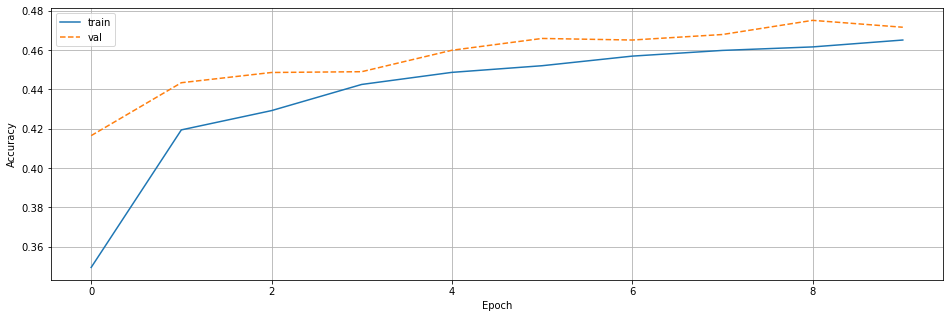

In [19]:
plt.figure(figsize = (16,5))
plt.plot(train_acc,'-',label = f'train')
plt.plot(test_acc,'--',label = f'val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()  

Так в чем же отличия и преимущества применения предтренированной сети, такой как Resnet-50? Сам процесс обучения быстрее, это очевидно, однако метрики качества значительно отстают от рукописной сети. На трейне Accuracy - 0.465, на тесте - 0.471, что почти вдвое меньше показателей собственной сети. Однако мы можем наблюдать интересную картину, которая отличается от собственной сети тем, что показывает более плавное обучение, показатели в первом случае на трейне выше, чем на тесте, а с предобученой сетью наоборот: тестовые выше тренировоных, рост плавнй без скачков и просадок.